Relevance CAM: Your Model Already Knows Where to Look  
https://github.com/mongeoroo/Relevance-CAM

- [InDepth: Layer-Wise Relevance Propagation](https://towardsdatascience.com/indepth-layer-wise-relevance-propagation-340f95deb1ea)


In [1]:
import sys, os, argparse, glob
# from glob import glob
import numpy as np
import pandas as pd
import torch
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import Dataset
from torchsummary import summary
import cv2
import skimage.io
import skimage.transform
import imageio

import matplotlib.cm
import matplotlib.pyplot as plt

# from modules.vgg import vgg16, vgg16_bn, VGG_spread, vgg19, vgg19_bn
# from modules.resnet import resnet50, resnet101, resnet18
from aa_rcam_resnet import resnet50_classifier
from imagenet_index import index2class
from LRP_util import GradCAM_multi, ScoreCAM, CLRP, preprocess_image, threshold 

path_root =  '/home/jovyan/Autoencoder'

ModuleNotFoundError: No module named 'layers'

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
parser = argparse.ArgumentParser()

parser.add_argument('--models', type=str, default='resnet50',
                    help='resnet50 or vgg16')
parser.add_argument('--target_layer', type=str, default='layer1',
                    help='target_layer')
parser.add_argument('--target_class', type=int, default=None,
                    help='target_class')

# args = parser.parse_args()
args = parser.parse_args(args=[]) # in jupyter 

In [4]:
metadata = f'{path_root}/meta/moth_meta_20210610.csv'
moth_meta = pd.read_csv(metadata)
# 取得檔案名稱加入欄位內
dataroot = "/home/jovyan/Autoencoder/wolrdwide_lepidoptera_yolov4_cropped_and_padded_20210610"
image_list = glob.glob(dataroot + '/*.jpg')  # 如果資料乾淨的話，可直接用 os.listdir(dataroot)
moth_meta['ImgPath'] = image_list

fam_dict = dict(
    zip(range(90), np.sort(moth_meta.Family.unique())
    ) 
) 

In [5]:
# 讀取benchmarks
metadata = f'{path_root}/meta/moth_benchmarks_meta_20210709.csv'
moth_bh_meta = pd.read_csv(metadata)
# 取得檔案名稱加入欄位內
dataroot = "/home/jovyan/Autoencoder/benchmarks"
image_list = glob.glob(dataroot + '/*.jpg')  # 如果資料乾淨的話，可直接用 os.listdir(dataroot)
image_list.sort()
moth_bh_meta['ImgPath'] = image_list

In [6]:
class ImgDataset(Dataset):
    '''簡單用來抽樣看原始圖檔的Dataset
        X: ImagePath
        y: Imagelabel(Family, Genus ,Specie Name etc...)
    '''
    def __init__(self, X, y, size=(256,256)):
        self.ImgNames  = np.asarray(X)                # 輸入的X 為影像完整路徑的list、y則為完整的科名list 
        self.labels = np.asarray(y).astype('int16') 
        self.size = size
        self.to_tensor = transforms.ToTensor()        # 將取值範圍為[0, 255]的PIL.Image或形狀為[H, W, C]的numpy.ndarray，轉換成形狀為[C, H, W]，取值範圍是[0, 1.0]的torch.FloadTensor
#         self.transform = transforms.Compose([       # 影像必須用PIL讀取才能使用transforms.Compose等系列操作
#             transforms.Resize(size=(128, 128)),
#             transforms.ToTensor()
#         ])
        
    def __getitem__(self, index):
        img_Name = self.ImgNames[index]
#         image = PILImage.open(img_Name)                #  PIL Image讀讀取影像的通道為(c,w,h)
        image = skimage.io.imread(img_Name)              #  skimage.io讀取影像的通道為(w,h,c)，to_tensor會自動調整  
        image = skimage.transform.resize(image, self.size)
        image = self.to_tensor(image).float()            # 根據檔名開啟影像。得到image.jpg的物件，並轉為Tensor
        label  = self.labels[index] 
        return image, label
    
    def __len__(self):
        return len(self.labels)
    
    # help to get images for visualizing
    def getbatch(self, indices):
        images = []
        labels = []
        for index in indices:
            image, label = self.__getitem__(index)
            images.append(image)
            labels.append(label)
        return torch.stack(images), torch.tensor(labels)

# 一次預讀取讀取所有影像 
X = moth_meta.ImgPath
y = moth_meta.Family_encode
img_set = ImgDataset(X=X, y=y)
class_names = moth_meta.Family  # Series


# 一次預讀取讀取所有bencemarks影像 
X_bh = moth_bh_meta.ImgPath
y_bh = moth_bh_meta.Family_encode
img_bh_set = ImgDataset(X=X_bh, y=y_bh)
class_names = moth_bh_meta.Family  # Series

In [7]:
# benchmarks
images, labels = img_bh_set.getbatch(range(30))   # torch.Size([b, c, w, h]
# print(img_indices)
print(labels)
print([fam_dict[label.item()] for label in labels])
# images = images.requires_grad_().to(device)          

tensor([ 1,  1,  3, 10, 19, 27, 34, 39, 39, 48, 48, 48, 48, 48, 61, 61, 61, 61,
        61, 61, 61, 61, 64, 65, 65, 74, 79, 79, 89, 89], dtype=torch.int16)
['Adelidae', 'Adelidae', 'Alucitidae', 'Brahmaeidae', 'Crambidae', 'Erebidae', 'Geometridae', 'Hesperiidae', 'Hesperiidae', 'Lycaenidae', 'Lycaenidae', 'Lycaenidae', 'Lycaenidae', 'Lycaenidae', 'Nymphalidae', 'Nymphalidae', 'Nymphalidae', 'Nymphalidae', 'Nymphalidae', 'Nymphalidae', 'Nymphalidae', 'Nymphalidae', 'Papilionidae', 'Pieridae', 'Pieridae', 'Saturniidae', 'Sphingidae', 'Sphingidae', 'Zygaenidae', 'Zygaenidae']


In [8]:
 def plot_GradCAM_multi(figsize=(10, 5.5), flag="mean", q=0.3, save=False):
    """
        flag :　"mean", "median", "quantile"
    """
    fig = plt.figure(figsize=figsize)
    fig.suptitle(f"{layer_path}, Class : {fam_dict[class_idx]}", fontsize=20)
    fontsize = 14
    cmap = "jet"

    plt.subplots_adjust(bottom=0.01)

    plt.subplot(2, 5, 1)
    plt.imshow(img_show)
    plt.title('Original')
    plt.axis('off')

    plt.subplot(2, 5, 1 + 5)
    plt.imshow(img_show)
    plt.axis('off')

    plt.subplot(2, 5, 2)
    plt.imshow((grad_cam), cmap=cmap)
    plt.imshow(img_show, alpha=.5)
    plt.title('Grad CAM', fontsize=fontsize)
    plt.axis('off')

    plt.subplot(2, 5, 2 + 5)
    plt.imshow(img_show*threshold(grad_cam, flag=flag, q=q)[..., np.newaxis])
    plt.title('Grad CAM', fontsize=fontsize)
    plt.axis('off')

    plt.subplot(2, 5, 3)
    plt.imshow((grad_campp), cmap=cmap)
    plt.imshow(img_show, alpha=.5)
    plt.title('Grad CAM++', fontsize=fontsize)
    plt.axis('off')

    plt.subplot(2, 5, 3 + 5)
    plt.imshow(img_show*threshold(grad_campp, flag=flag)[..., np.newaxis])
    plt.title('Grad CAM++', fontsize=fontsize)
    plt.axis('off')

    plt.subplot(2, 5, 4)
    plt.imshow((score_map), cmap=cmap)
    plt.imshow(img_show, alpha=.5)
    plt.title('Score_CAM', fontsize=15)
    plt.axis('off')

    plt.subplot(2, 5, 4 + 5)
    plt.imshow(img_show*threshold(score_map, flag=flag, q=q)[...,np.newaxis])
    plt.title('Score_CAM', fontsize=15)
    plt.axis('off')

    plt.subplot(2, 5, 5)
    plt.imshow((R_CAM), cmap=cmap)
    plt.imshow(img_show, alpha=.5)
    plt.title('Relevance_CAM', fontsize=fontsize)
    plt.axis('off')

    plt.subplot(2, 5, 5 + 5)
    plt.imshow(img_show*threshold(R_CAM, flag=flag, q=q)[...,np.newaxis])
    plt.title('Relevance_CAM', fontsize=fontsize)
    plt.axis('off')

#     plt.tight_layout()
    plt.draw()
    # plt.waitforbuttonpress()
    if save==True:
        save_path = f"./results//benchmarks/{layer_path}_Class:{label_family}_{img_path_long.split('/')[-1]}"
        plt.savefig(save_path, bbox_inches='tight')
#     plt.clf()
#     plt.close()

In [9]:
model_arch = args.models
num_classes = 90 # 自定義 resnet50的輸出為90(科)

if model_arch == 'vgg16':
    model = vgg16_bn(pretrained=True).to(device).eval()  #####
    target_layer = model.features[int(args.target_layer)]
    layer_path = int(args.target_layer)
elif model_arch == 'resnet50':
    model = resnet50(num_classes=num_classes, pretrained=False).to(device).eval() #####
    if args.target_layer == 'layer1':
        target_layer = model.layer1
    elif args.target_layer == 'layer2':
        target_layer = model.layer2
    elif args.target_layer == 'layer3':
        target_layer = model.layer3
    elif args.target_layer == 'layer4':
        target_layer = model.layer4
    layer_path = args.target_layer

In [9]:
# 載入自定義模型訓練進度
# Load pth
resnet_pretrained = torch.load(
    "/home/jovyan/Autoencoder/model/vsc_wgan/pretrained_fam_classification_resnet50_20210613.pth", 
    map_location=lambda storage, loc: storage.cuda(1)                                         # optoonal 將model從原本預設的讀取位置指定到cuda(1) 
)
pretrained_dict, resnet50_dict = resnet_pretrained['model_state'], model.state_dict()         # 載入權重參數
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in resnet50_dict}            # 更新pretrained model的key與value，使之與resnet50一致
resnet50_dict.update(pretrained_dict)                                                         # 將resnet50的權重更新為pretrained model
model.load_state_dict(resnet50_dict)                                                          # 將pretrained的權重載入resnet50

NameError: name 'model' is not defined

In [47]:
resnet_pretrained = torch.load(
    "/home/jovyan/Autoencoder/model/vsc_wgan/pretrained_fam_classification_resnet50_20210613.pth", 
    map_location=lambda storage, loc: storage.cuda(1)                                         # optoonal 將model從原本預設的讀取位置指定到cuda(1) 
)
pretrained_dict, resnet50_dict = resnet_pretrained['model_state'], model.state_dict()         # 載入權重參數
pretrained_dict = {k : v for k, v in pretrained_dict.items() if k not in resnet50_dict}  

In [50]:
resnet_pretrained = torch.load(
    "/home/jovyan/Autoencoder/model/vsc_wgan/pretrained_fam_classification_resnet50_20210613.pth", 
    map_location=lambda storage, loc: storage.cuda(1)                                         # optoonal 將model從原本預設的讀取位置指定到cuda(1) 
)
pretrained_dict, resnet50_dict = resnet_pretrained['model_state'], model.state_dict()         # 載入權重參數
for k, v in pretrained_dict.items():
    if k in resnet50_dict:
        print(k)

fc.weight
fc.bias


In [ ]:
model = model.cpu()
model.eval()
with torch.no_grad():
    outputs = model(images)
preds = torch.argmax(outputs, dim=1).detach().numpy()

print([fam_dict[pred] for pred in preds])

In [ ]:

from modules.resnet50_classifier import ResNet50_family_classifier # 載入映妤客製的resnet50分科模型

# device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

resnet50 = ResNet50_family_classifier(getDeepFeature=False).to(device)                        # getDeepFeature=False for get prediction only(else for feature map)

# Load pth
resnet_pretrained = torch.load(
    f"{path_root}/model/vsc_wgan/pretrained_fam_classification_resnet50_20210613.pth", 
    map_location=lambda storage, loc: storage.cpu()                                         # optoonal 將model從原本預設的讀取位置指定到cuda(1) 
)
pretrained_dict, resnet50_dict = resnet_pretrained['model_state'], resnet50.state_dict()      # 載入權重參數
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in resnet50_dict}            # 更新pretrained model的key與value，使之與resnet50一致
resnet50_dict.update(pretrained_dict)                                                         # 將resnet50的權重更新為pretrained model
resnet50.load_state_dict(resnet50_dict)                                                       # 將pretrained的權重載入resnet50



In [10]:
# 評估模型摘要
from torchsummary import summary
import torchvision
device = torch.device("cpu")
input_size = (3, 128, 128)
batch_size = 1

model = torchvision.models.resnet50()

summary(model.to(device), input_size=input_size, batch_size=batch_size, device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [1, 64, 64, 64]           9,408
       BatchNorm2d-2            [1, 64, 64, 64]             128
              ReLU-3            [1, 64, 64, 64]               0
         MaxPool2d-4            [1, 64, 32, 32]               0
            Conv2d-5            [1, 64, 32, 32]           4,096
       BatchNorm2d-6            [1, 64, 32, 32]             128
              ReLU-7            [1, 64, 32, 32]               0
            Conv2d-8            [1, 64, 32, 32]          36,864
       BatchNorm2d-9            [1, 64, 32, 32]             128
             ReLU-10            [1, 64, 32, 32]               0
           Conv2d-11           [1, 256, 32, 32]          16,384
      BatchNorm2d-12           [1, 256, 32, 32]             512
           Conv2d-13           [1, 256, 32, 32]          16,384
      BatchNorm2d-14           [1, 256,

In [8]:
# 評估模型摘要
from torchsummary import summary
device = torch.device("cpu")
input_size = (3, 128, 128)
batch_size = 1

summary(resnet50.to(device), input_size=input_size, batch_size=batch_size, device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [1, 64, 64, 64]           9,408
       BatchNorm2d-2            [1, 64, 64, 64]             128
              ReLU-3            [1, 64, 64, 64]               0
         MaxPool2d-4            [1, 64, 63, 63]               0
   ReflectionPad2d-5            [1, 64, 66, 66]               0
          BlurPool-6            [1, 64, 32, 32]               0
            Conv2d-7            [1, 64, 32, 32]           4,096
       BatchNorm2d-8            [1, 64, 32, 32]             128
              ReLU-9            [1, 64, 32, 32]               0
           Conv2d-10            [1, 64, 32, 32]          36,864
      BatchNorm2d-11            [1, 64, 32, 32]             128
             ReLU-12            [1, 64, 32, 32]               0
           Conv2d-13           [1, 256, 32, 32]          16,384
      BatchNorm2d-14           [1, 256,

In [25]:

resnet50.eval()
with torch.no_grad():
    outputs = resnet50(images)
preds = torch.argmax(outputs, dim=1).detach().numpy()

print([fam_dict[pred] for pred in preds])

['Adelidae', 'Adelidae', 'Pterophoridae', 'Brahmaeidae', 'Crambidae', 'Erebidae', 'Geometridae', 'Hesperiidae', 'Hesperiidae', 'Riodinidae', 'Lycaenidae', 'Lycaenidae', 'Hesperiidae', 'Riodinidae', 'Nymphalidae', 'Nymphalidae', 'Nymphalidae', 'Nymphalidae', 'Nymphalidae', 'Nymphalidae', 'Nymphalidae', 'Nymphalidae', 'Papilionidae', 'Pieridae', 'Pieridae', 'Saturniidae', 'Sphingidae', 'Sphingidae', 'Zygaenidae', 'Zygaenidae']


In [39]:
for name, module in model.named_children():
    print(name)

conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc


In [40]:
for name, module in resnet50.named_children():
    print(name)

conv1
conv2_x
conv3_x
conv4_x
conv5_x
avgpool
fc


Pred : Geometridae
True : Papilionidae


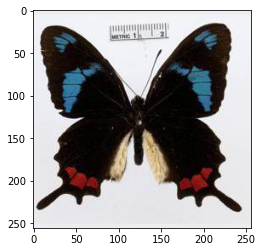

In [11]:
# path_s = os.listdir('/home/jovyan/Autoencoder/benchmarks')
# path = path_s[7]
image = images[22].unsqueeze(dim=0)
label = labels[22].item()
size = (256, 256) 
label

img_show  = image[0].detach().cpu().permute(1, 2, 0).numpy()

in_tensor = image.clone().to(device)
output = model(in_tensor)                          # torch.Size([1, 1000])

# 取得index
if args.target_class == None:
    maxindex = np.argmax(output.detach().cpu().numpy())
else:
    maxindex = args.target_class

class_idx = maxindex

print(f"Pred : {fam_dict[maxindex]}")
print(f"True : {fam_dict[label]}")

plt.imshow(img_show);

In [28]:
# CAM_CLASS = a(model, target_layer)
# Score_CAM_class = ScoreCAM(model, target_layer)

# img_path_long = '/home/jovyan/Autoencoder/benchmarks/{}'.format(path)
# img = cv2.imread(img_path_long, 1)                 # flag == 1 , cv2.IMREAD_COLOR 
# img_show = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)    
# img_show = cv2.resize(img_show, size)         # (w, h, c)。RGB  
# img = np.float32(cv2.resize(img, size))/255   # (w, h, c)。BGR 

# in_tensor = preprocess_image(img).to(device)       # 標準化、BGRtoRGB 、並轉為tensor。torch.Size([batch, c, w, h])) 。RGB   

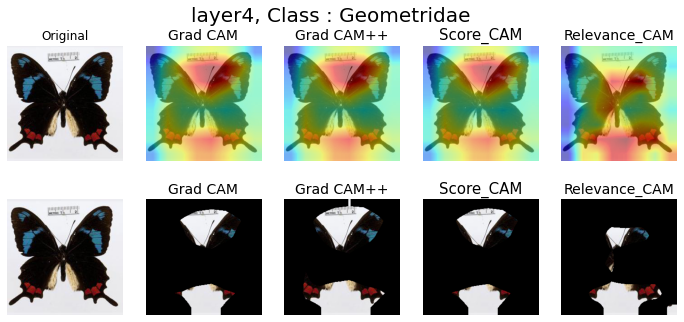

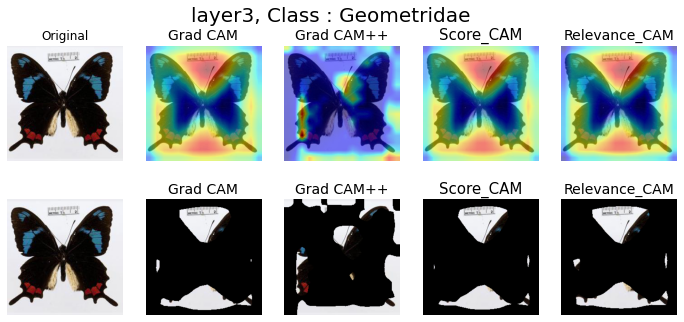

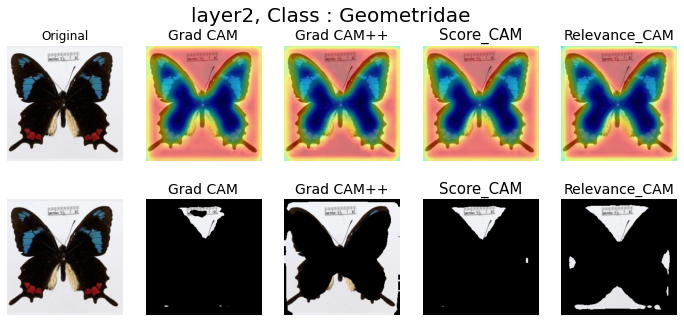

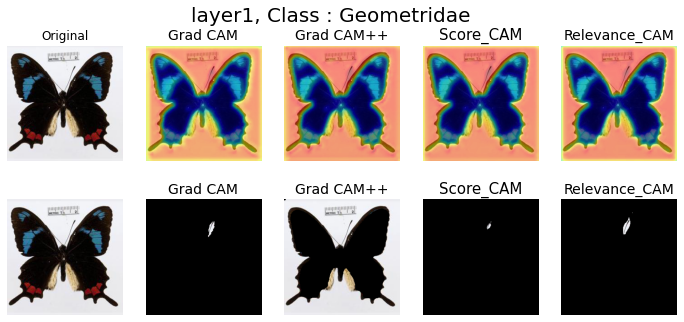

In [12]:

for args.target_layer in ["layer4", "layer3", "layer2", "layer1"]:
    if args.target_layer == 'layer1':
        target_layer = model.layer1
    elif args.target_layer == 'layer2':
        target_layer = model.layer2
    elif args.target_layer == 'layer3':
        target_layer = model.layer3
    elif args.target_layer == 'layer4':
        target_layer = model.layer4
    layer_path = args.target_layer
    
    CAM_CLASS = GradCAM_multi(model, target_layer)
    Score_CAM_class = ScoreCAM(model, target_layer)

#     img_show  = image[0].detach().cpu().permute(1, 2, 0).numpy()
#     in_tensor = image
#     output = model(in_tensor)                          # torch.Size([1, 1000])

#     # 取得index
#     if args.target_class == None:
#         maxindex = np.argmax(output.detach().cpu().numpy())
#     else:
#         maxindex = args.target_class

#     class_idx = maxindex

#     print(f"Pred : {fam_dict[maxindex]}")
#     print(f"True : {fam_dict[label]}")

    # 計算KRP權重
    Tt, Tn = CLRP(output, class_idx, num_classes=num_classes)
    posi_R = model.relprop(Tt, 1, flag=layer_path).detach().cpu().numpy()
    nega_R = model.relprop(Tn, 1, flag=layer_path).detach().cpu().numpy()

    R = posi_R - nega_R
    R = np.transpose(R[0],(1,2,0))                   # (w, h, filter_number)            
    r_weight = np.sum(R, axis=(0,1) ,keepdims=True)  # (1, 1, filter_number)
    activation, grad_cam, grad_campp = CAM_CLASS(in_tensor, class_idx=class_idx)

    R_CAM = cv2.resize(np.sum(activation * r_weight, axis=-1), size)  # (1, 1, filter_number) * (w, h, filter_number)  >　(w, h) : filter size
    

    score_map, _ = Score_CAM_class(in_tensor, class_idx=class_idx)
    score_map = score_map.squeeze()
    score_map = score_map.detach().cpu().numpy()

    plot_GradCAM_multi(figsize=(12, 4.5), flag="quantile", q=0.45, save=False)

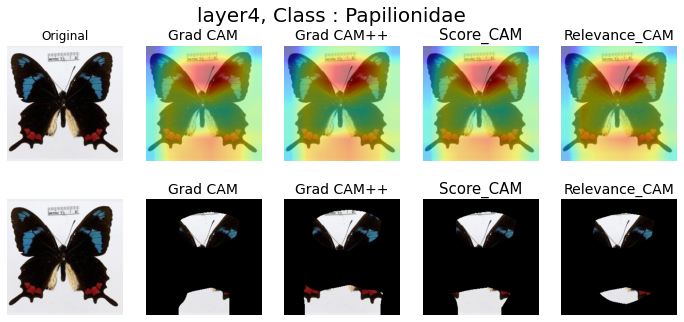

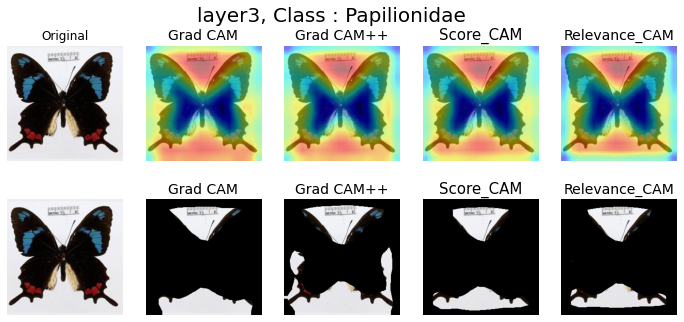

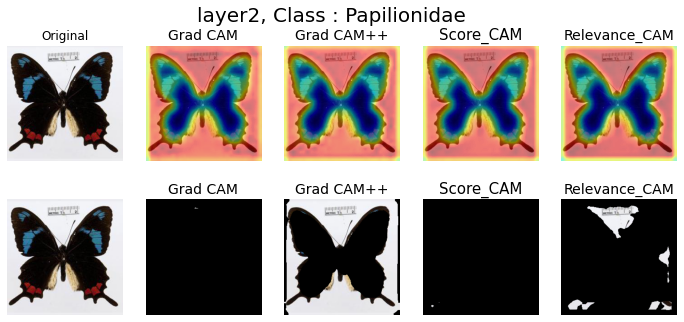

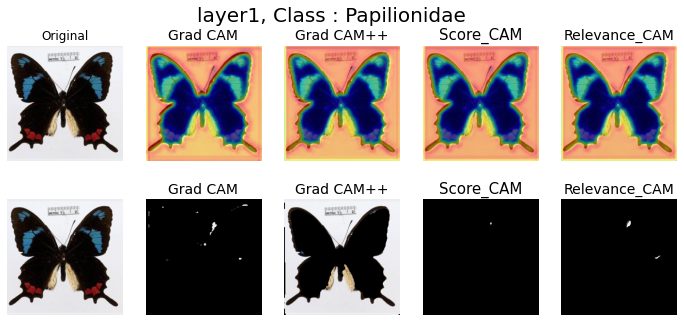

In [42]:
class_idx = label
for args.target_layer in ["layer4", "layer3", "layer2", "layer1"]:
    if args.target_layer == 'layer1':
        target_layer = model.layer1
    elif args.target_layer == 'layer2':
        target_layer = model.layer2
    elif args.target_layer == 'layer3':
        target_layer = model.layer3
    elif args.target_layer == 'layer4':
        target_layer = model.layer4
    layer_path = args.target_layer
    
    CAM_CLASS = GradCAM_multi(model, target_layer)
    Score_CAM_class = ScoreCAM(model, target_layer)

#     img_show  = image[0].detach().cpu().permute(1, 2, 0).numpy()
#     in_tensor = image
#     output = model(in_tensor)                          # torch.Size([1, 1000])

#     # 取得index
#     if args.target_class == None:
#         maxindex = np.argmax(output.detach().cpu().numpy())
#     else:
#         maxindex = args.target_class

#     print(f"Pred : {fam_dict[maxindex]}")
#     print(f"True : {fam_dict[label]}")

    # 計算KRP權重
    Tt, Tn = CLRP(output, class_idx, num_classes=num_classes)
    posi_R = model.relprop(Tt, 1, flag=layer_path).detach().cpu().numpy()
    nega_R = model.relprop(Tn, 1, flag=layer_path).detach().cpu().numpy()

    R = posi_R - nega_R
    R = np.transpose(R[0],(1,2,0))                   # (w, h, filter_number)            
    r_weight = np.sum(R, axis=(0,1) ,keepdims=True)  # (1, 1, filter_number)
    in_tensor = image.clone()
    activation, grad_cam, grad_campp = CAM_CLASS(in_tensor, class_idx=class_idx)

    R_CAM = cv2.resize(np.sum(activation * r_weight, axis=-1), size)  # (1, 1, filter_number) * (w, h, filter_number)  >　(w, h) filter size
    
    in_tensor = image.clone()
    score_map, _ = Score_CAM_class(in_tensor, class_idx=class_idx)
    score_map = score_map.squeeze()
    score_map = score_map.detach().cpu().numpy()

    plot_GradCAM_multi(figsize=(12, 4.5), flag="quantile", q=0.45, save=False)

In [ ]:
# for args.target_layer in ["layer4", "layer3", "layer2", "layer1"]:
#     if args.target_layer == 'layer1':
#         target_layer = model.layer1
#     elif args.target_layer == 'layer2':
#         target_layer = model.layer2
#     elif args.target_layer == 'layer3':
#         target_layer = model.layer3
#     elif args.target_layer == 'layer4':
#         target_layer = model.layer4
#     layer_path = args.target_layer
    
#     CAM_CLASS = GradCAM_multi(model, target_layer)
#     Score_CAM_class = ScoreCAM(model, target_layer)

#     img_show  = image[0].detach().cpu().permute(1, 2, 0).numpy()
#     in_tensor = image
#     output = model(in_tensor)                          # torch.Size([1, 1000])

#     # 取得index
#     if args.target_class == None:
#         maxindex = np.argmax(output.detach().cpu().numpy())
#     else:
#         maxindex = args.target_class

#     label_family = img_path_long.split('/')[-1].split('_')[0]
#     label = [eccode  for eccode, family in fam_dict.items() if family == label_family][0]

#     print(f"Pred : {fam_dict[maxindex]}")
#     print(f"True : {label_family}")

#     # 計算KRP權重
#     Tt, Tn = CLRP(output, label)
#     posi_R = model.relprop(Tt, 1, flag=layer_path).detach().cpu().numpy()
#     nega_R = model.relprop(Tn, 1, flag=layer_path).detach().cpu().numpy()

#     R = posi_R - nega_R
#     R = np.transpose(R[0],(1,2,0))                   # (w, h, filter_number)            
#     r_weight = np.sum(R, axis=(0,1) ,keepdims=True)  # (1, 1, filter_number)
#     activation, grad_cam, grad_campp = CAM_CLASS(in_tensor, class_idx=maxindex)

#     R_CAM = cv2.resize(np.sum(activation * r_weight, axis=-1), size)  # (1, 1, filter_number) * (w, h, filter_number)  >　(w, h) filter size

#     score_map, _ = Score_CAM_class(in_tensor, class_idx=maxindex)
#     score_map = score_map.squeeze()
#     score_map = score_map.detach().cpu().numpy()

#     plot_GradCAM_multi(figsize=(12, 4.5), flag="mean", q=0.4, save=False)

## 確認預測結果準確度m